![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [55]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [56]:
df = pd.read_csv('rental_info.csv')
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [57]:
print(df.info())
print(df.mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB
None
amount                  4

D:\users\User\AppData\Local\Temp\ipykernel_18268\2935827682.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.mean())


In [58]:
df['return_date'] = pd.to_datetime(df['return_date'])
df['rental_date'] = pd.to_datetime(df['rental_date'])

df['rental_length_days'] = (df['return_date']- df['rental_date']).dt.days
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4


In [59]:
df["deleted_scenes"] =  np.where(df["special_features"].str.contains("Deleted Scenes"), 1,0)
df["behind_the_scenes"] =  np.where(df["special_features"].str.contains("Behind the Scenes"), 1,0)
df.tail(10)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
15851,2005-07-29 11:07:48+00:00,2005-08-07 12:56:48+00:00,4.99,2004.0,2.99,72.0,15.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,24.9001,5184.0,8.9401,9,0,1
15852,2005-08-19 02:52:13+00:00,2005-08-21 21:22:13+00:00,2.99,2004.0,2.99,72.0,15.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,5184.0,8.9401,2,0,1
15853,2005-08-01 02:10:54+00:00,2005-08-09 23:04:54+00:00,4.99,2004.0,2.99,72.0,15.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,24.9001,5184.0,8.9401,8,0,1
15854,2005-08-23 00:44:06+00:00,2005-08-30 02:34:06+00:00,2.99,2004.0,2.99,72.0,15.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,5184.0,8.9401,7,0,1
15855,2005-07-29 18:30:23+00:00,2005-08-01 14:32:23+00:00,4.99,2009.0,4.99,88.0,11.99,"{Trailers,""Deleted Scenes"",""Behind the Scenes""}",0,0,0,1,24.9001,7744.0,24.9001,2,1,1
15856,2005-08-22 10:49:15+00:00,2005-08-29 09:52:15+00:00,6.99,2009.0,4.99,88.0,11.99,"{Trailers,""Deleted Scenes"",""Behind the Scenes""}",0,0,0,1,48.8601,7744.0,24.9001,6,1,1
15857,2005-07-31 09:48:49+00:00,2005-08-04 10:53:49+00:00,4.99,2009.0,4.99,88.0,11.99,"{Trailers,""Deleted Scenes"",""Behind the Scenes""}",0,0,0,1,24.9001,7744.0,24.9001,4,1,1
15858,2005-08-20 10:35:30+00:00,2005-08-29 13:03:30+00:00,8.99,2009.0,4.99,88.0,11.99,"{Trailers,""Deleted Scenes"",""Behind the Scenes""}",0,0,0,1,80.8201,7744.0,24.9001,9,1,1
15859,2005-07-31 13:10:20+00:00,2005-08-08 14:07:20+00:00,7.99,2009.0,4.99,88.0,11.99,"{Trailers,""Deleted Scenes"",""Behind the Scenes""}",0,0,0,1,63.8401,7744.0,24.9001,8,1,1
15860,2005-08-18 06:33:55+00:00,2005-08-24 07:14:55+00:00,5.99,2009.0,4.99,88.0,11.99,"{Trailers,""Deleted Scenes"",""Behind the Scenes""}",0,0,0,1,35.8801,7744.0,24.9001,6,1,1


In [60]:
df.columns

Index(['rental_date', 'return_date', 'amount', 'release_year', 'rental_rate',
       'length', 'replacement_cost', 'special_features', 'NC-17', 'PG',
       'PG-13', 'R', 'amount_2', 'length_2', 'rental_rate_2',
       'rental_length_days', 'deleted_scenes', 'behind_the_scenes'],
      dtype='object')

In [80]:
cols_to_drop = ['special_features', 'rental_length_days', 'rental_date', 'return_date']


X = df.drop(cols_to_drop, axis=1)
y = df["rental_length_days"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
X.shape

(15861, 14)

In [62]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)


X_train shape: (12688, 13)
X_test shape: (3173, 13)
y_train shape: (12688,)


In [63]:
model_lasso = Lasso(alpha=0.3, random_state=9)
model_lasso.fit(X_train, y_train)

model_lasso_coef = model_lasso.coef_ #indicate the importance of each feature
X_lasso_train, X_lasso_test = X_train.iloc[:, model_lasso_coef>0], X_test.iloc[:, model_lasso_coef>0]
X_lasso_test

,amount,amount_2,length_2
15067,4.99,24.9001,33856.0
3808,4.99,24.9001,32041.0
1015,4.99,24.9001,5329.0
12617,4.99,24.9001,29584.0
1711,4.99,24.9001,8281.0
...,...,...,...
2828,2.99,8.9401,16641.0
8917,9.99,99.8001,17956.0
13592,0.99,0.9801,17956.0
7739,2.99,8.9401,19881.0


In [64]:
model_lasso_coef


array([ 5.84104436e-01,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        4.36220099e-02,  3.01167814e-06, -1.52983562e-01, -0.00000000e+00,
        0.00000000e+00])

In [65]:
lin_rg = LinearRegression()
lin_rg.fit(X_lasso_train, y_train)
y_test_predict = lin_rg.predict(X_lasso_test)
y_test_predict


array([4.77198298, 4.77755886, 4.85962114, ..., 2.79341627, 3.68331058,
       4.25414451])

In [66]:
mean_squared_error(y_test, y_test_predict)

4.812297241276239

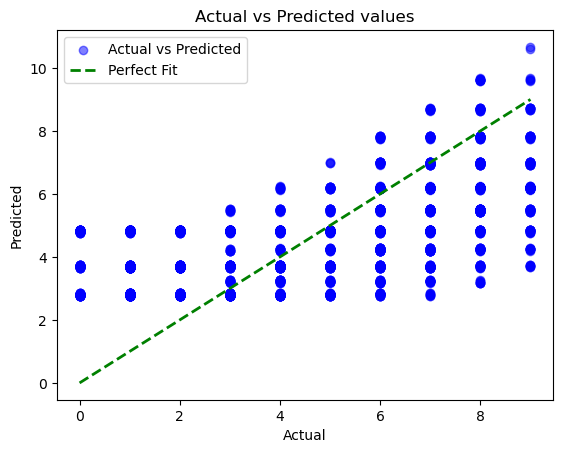

In [67]:
plt.scatter(y_test, y_test_predict, alpha=0.5, color='blue', label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='green', linewidth=2, label='Perfect Fit')

plt.title('Actual vs Predicted values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

In [72]:
param_dist = {'n_estimators': np.arange(100,200,1), 'max_depth':np.arange(1,11,1) }

rfg = RandomForestRegressor()
rand_search = RandomizedSearchCV(rfg, param_distributions=param_dist, cv=5, random_state=9)
rand_search.fit(X_train, y_train)
hyper_params = rand_search.best_params_

hyper_params

{'n_estimators': 150, 'max_depth': 10}

In [73]:
rfg = RandomForestRegressor(n_estimators=hyper_params['n_estimators'], max_depth=hyper_params['max_depth'], random_state=9)
rfg.fit(X_train, y_train)
rfg_predict = rfg.predict(X_test)
#rfg_predict
mse = mean_squared_error(y_test, rfg_predict)
mse

2.214133278474462

In [74]:
best_model = rfg 
best_mse = mse
